# Homework 2
## Nick Boddy<br>nboddy

Here I implement a decision tree "from scratch", using libraries only for convenience of data structuring and manipulation.

This implementation assumes that the data consists of continuous numeric features and a classification label in {0, 1}.
The tree makes splits using GainRatio. If it is determined that a leaf node contains no majority class, it defaults to "1".


Below the implementation I address concepts and questions regarding decision trees.

## 1.    A Simplified Decision Tree

In [60]:
import numpy as np
import pandas as pd
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from dataclasses import dataclass
from typing import List
%matplotlib inline

In [61]:
def determine_candidate_numeric_splits(D: pd.DataFrame, X: str) -> list((str, float)):
    C = []
    instances = D.sort_values(by=X)
    instances = instances.reset_index(drop=True)
    for i, row in instances.iterrows():
        if i < len(instances) - 1:
            y_i = row['y']
            y_next = instances.at[i + 1, 'y']
            x_next = instances.at[i + 1, X]
            if y_i != y_next and (X, x_next) not in C:
                C.append((X, x_next))
    return C

In [62]:
def determine_candidate_splits(D: pd.DataFrame) -> list((str, float)):
    C = []
    for feature in D.columns[:-1]:
        instances = D[:]
        C.extend(determine_candidate_numeric_splits(instances, feature))
    return C

In [63]:
def entropy_Y(D: pd.DataFrame, Y: str) -> float:
    # H(Y) = -Sum(P(y)*log2(P(y)) for each y in Y)
    H = 0
    y = D[Y].unique()
    for y_i in y:
        Py_i = sum(D[Y] == y_i) / len(D[Y])
        H += Py_i if Py_i == 0 else Py_i * math.log2(Py_i)
    H *= -1
    return H

def entropy_S(D: pd.DataFrame, S: (str, float)) -> float:
    # H(S) = -(P(X < c)*log2(P(X < c) + P(X >= c)*log2(P(X >= c)))
    # careful not to calculate log2(0)
    H = 0
    X, c = S
    Pgreater = sum(D[X] >= c) / len(D[X])
    H += Pgreater if Pgreater == 0 else Pgreater * math.log2(Pgreater)
    Plesser = sum(D[X] < c) / len(D[X])
    H += Plesser if Plesser == 0 else Plesser * math.log2(Plesser)
    H *= -1
    return H

def conditional_entropy(D: pd.DataFrame, Y: str, S: (str, float)) -> float:
    # H(Y | S) = (P(X >= c) * H(Y | X >= c)) + (P(X < c) * H(Y | X < c))
    H = 0
    X, c = S
    HYgreater = entropy_Y(D[D[X] >= c], Y)
    Pgreater = sum(D[X] >= c) / len(D[X])
    HYlesser = entropy_Y(D[D[X] < c], Y)
    Plesser = sum(D[X] < c) / len(D[X])
    H += Pgreater * HYgreater
    H += Plesser * HYlesser
    return H

In [64]:
@dataclass
class Node:
    feature: str = None
    threshold: float = None
    children: List['Node'] = None
    class_label: float = None
    layer: int = 0


    def predict(self, X: pd.Series) -> float:
        if self.class_label != None:
            return self.class_label
        elif self.feature and self.threshold and self.children:
            if X[self.feature] >= self.threshold:
                return self.children[0].predict(X)
            else:
                return self.children[1].predict(X)

    def size(self):
        sz = 1
        if self.children:
            for child in self.children:
                sz += child.size()
        return sz

    def __str__(self):
        result = ''
        if self.class_label != None:
            result += 'y = ' + str(self.class_label)
        elif self.feature and self.threshold:
            result += self.feature + ' >= ' + str(self.threshold)
        if self.children:
            result += '\n' + '\t'*self.layer + '|\n' + '\t'*self.layer + '├──' + str(self.children[0])
            result += '\n' + '\t'*self.layer + '|\n' + '\t'*self.layer + '└──' + str(self.children[1])
        return result if result else '<???>'

In [65]:
def make_subtree(D: pd.DataFrame, layer: int = 0) -> Node:
    stop = False
    best_split = None
    candidate_splits = determine_candidate_splits(D[:])
    # STOP if node is empty (or we have no splits)
    if len(D) == 0 or len(candidate_splits) == 0:
        stop = True
    else:
        gainRatios = []
        for split in candidate_splits:
            split_entropy = entropy_S(D, split)
            if split_entropy == 0:
                # found split with zero entropy (100% of the training instances are on one side)
                # ignore this, so set gainRatio to zero
                gainRatio = 0.0
                gainRatios.append(gainRatio)
            else:
                # GainRatio(D, Split) = (H(Y) - H(Y | Split)) / H(Split)
                gainRatio = (entropy_Y(D, 'y') - conditional_entropy(D, 'y', split)) / entropy_S(D, split)
                gainRatios.append(gainRatio)
        gainRatios = pd.Series(gainRatios)
        # STOP if all splits give 0 info (gainRatio)
        if len(gainRatios) == 0 or gainRatios.max() == 0:
            stop = True
        else:
            best_split = candidate_splits[gainRatios.idxmax()]
    if stop:
        # stopping criteria met
        # stop when there are no training instances, or 
        majority_class = D['y'].mode()
        if len(majority_class) > 1:
            majority_class = '1'
        else:
            majority_class = majority_class[0]
        new_node = Node(class_label=majority_class, layer=layer)
        return new_node
    else:
        # make internal node and make children subtrees
        feature, threshold = best_split
        left_data = D[D[feature] >= threshold]
        right_data = D[D[feature] < threshold]
        left_child = make_subtree(left_data, layer + 1)
        right_child = make_subtree(right_data, layer + 1)
        new_node = Node(feature, threshold, [left_child, right_child], layer=layer)
        return new_node

## 2.    Questions

### 1.
If a node is not empty but contains training items with the same label, why is it guaranteed to become a leaf? Explain. You may assume that the feature values of these items are not all the same.

If a node contains only training items of one label, say "1", it will always become a leaf because the algorithm will not produce any candidate splits (since when comparing every pair of adjacent feature values, they don't differ in label class).

Even in the case where my implementation differed and created candidate splits at every feature point, every candidate split would have either zero gain ratio or zero entropy, which triggers our stopping criteria.


### 2.
Handcraft a small training set where both classes are present but the algorithm refuses to split; instead it makes the root a leaf and stop; Importantly, if we were to manually force a split, the algorithm will happily continue splitting the data set further and produce a deeper tree with zero training error. You should (1) plot your training set, (2) explain why. Hint: you don’t need more than a handful of items.

In [66]:
q2_df = pd.DataFrame([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 0]])
q2_df.columns = ['x1', 'x2', 'y']
q2_df

,x1,x2,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [67]:
q2_dtree = make_subtree(q2_df)
print(q2_dtree)

y = 1


As we observe above, the decision tree made on the 4-row training data (q2_df), the tree consists of just a root node with class label y = 1.

This dataset doesn't allow the tree to split because it's designed in such a way that a split on any feature keeps P(y=0) equal to P(y=1). The dataset follows y:= x1 xor x2.

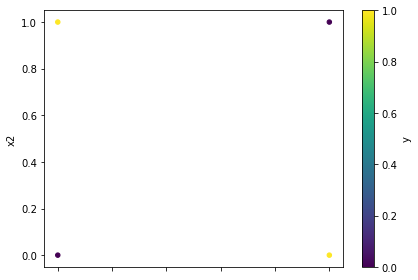

In [68]:
ax = q2_df.plot.scatter(x='x1', y='x2', c='y', colormap='viridis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.tight_layout()
plt.show()

Above is the plot of q2_df. Yellow indicates the point has classification label 1, and purple 0.

### 3.
Use the training set Druns.txt. For the root node, list all candidate cuts and their information gain ratio. If the entropy of the candidate split is zero, please list its mutual information (i.e. information gain). Hint: to get log2(x) when your programming language may be using a different base, use log(x)/log(2). Also, please follow the split rule in the first section.

In [69]:
druns_df = pd.read_csv('./data/Druns.txt', sep='\s+', names=['x1', 'x2', 'y'])
druns_df

,x1,x2,y
0,0.1,-2,0
1,0.0,-1,1
2,0.0,0,0
3,0.0,1,0
4,0.0,2,0
5,0.0,3,0
6,0.0,4,0
7,0.0,5,0
8,0.0,6,1
9,0.0,7,0


In [70]:
druns_root_splits = determine_candidate_splits(druns_df)
ratios = []
print('Root candidate cuts: ')
for split in druns_root_splits:
    HS = entropy_S(druns_df, split)
    HY = entropy_Y(druns_df, 'y')
    HYS = conditional_entropy(druns_df, 'y', split)
    if HS == 0:
        infoGain = HY - HYS
        print('[' + split[0] + ' >= ' + str(split[1]) + ']: ' + str(infoGain) + ' (zero split entropy)')
    else:
        gainRatio = (HY - HYS) / HS
        print('[' + split[0] + ' >= ' + str(split[1]) + ']: ' + str(gainRatio))

Root candidate cuts: 
[x1 >= 0.0]: 0.0 (zero split entropy)
[x1 >= 0.1]: 0.10051807676021852
[x2 >= -1]: 0.10051807676021852
[x2 >= 0]: 0.055953759631263686
[x2 >= 6]: 0.2360996061436081
[x2 >= 7]: 0.055953759631263686
[x2 >= 8]: 0.43015691613098095


### 4.
Decision tree is not the most accurate classifier in general. However, it persists. This is largely due to its rumored interpretability: a data scientist can easily explain a tree to a non-data scientist. Build a tree from D3leaves.txt. Then manually convert your tree to a set of logic rules. Show the tree and the rules.

In [71]:
d3_df = pd.read_csv('./data/D3leaves.txt', sep='\s+', names=['x1', 'x2', 'y'])
d3_df

,x1,x2,y
0,10,1,1
1,10,2,1
2,10,3,1
3,1,1,0
4,1,3,1


In [72]:
d3_dtree = make_subtree(d3_df)
print(d3_dtree)

x2 >= 2
|
├──y = 1
|
└──x1 >= 10
	|
	├──y = 1
	|
	└──y = 0


The decision tree created above can also be illustrated as:
```
           ┌─true───┤y = 1
           │
x2 >= 2 ───┤                     ┌─true───┤y = 1
           │                     │
           └─false──┤x1 >= 10├───┤
                                 │
                                 └─false──┤y = 0
```
This represents the following logical expression:
```
    y = 1 if x2 >= 2 or x1 >= 10
    y = 0 otherwise
```

### 5.
For this question only, make sure you DO NOT VISUALIZE the data sets or plot your tree’s decision boundary in the 2D x space. If your code does that, turn it off before proceeding. This is because you want to see your own reaction when trying to interpret a tree. You will get points no matter what your interpretation is. And we will ask you to visualize them in the next question anyway.
- Build a decision tree on D1.txt. Show it to us in any format (e.g. could be a standard binary tree with nodes and arrows, and denote the rule at each leaf node; or as simple as plaintext output where each line represents a node with appropriate line number pointers to child nodes; whatever is convenient for you). Again, do not visualize the data set or the tree in the x input space. In real tasks you will not be able to visualize the whole high dimensional input space anyway, so we don’t want you to “cheat” here.
- Look at your tree in the above format (remember, you should not visualize the 2D dataset or your tree’s decision boundary) and try to interpret the decision boundary in human understandable English.
- Build a decision tree on D2.txt. Show it to us.
- Try to interpret your D2 decision tree. Is it easy or possible to do so without visualization?

In [73]:
d1_df = pd.read_csv('./data/D1.txt', sep='\s+', names=['x1', 'x2', 'y'])
d1_dtree = make_subtree(d1_df)
print(d1_dtree)

x2 >= 0.201829
|
├──y = 1
|
└──y = 0


The decision tree built on D1.txt is above. It has a depth of 2 and appears to be fairly simple. If x2 is greater than or equal to 0.201829, we predict y to be 1.

In [74]:
d2_df = pd.read_csv('./data/D2.txt', sep='\s+', names=['x1', 'x2', 'y'])
d2_dtree = make_subtree(d2_df)
print(d2_dtree)

x1 >= 0.533076
|
├──x2 >= 0.228007
	|
	├──x2 >= 0.424906
		|
		├──y = 1
		|
		└──x1 >= 0.708127
			|
			├──y = 1
			|
			└──x2 >= 0.32625
				|
				├──x1 >= 0.595471
					|
					├──x1 >= 0.646007
						|
						├──y = 1
						|
						└──x2 >= 0.403494
							|
							├──y = 1
							|
							└──y = 0
					|
					└──y = 0
				|
				└──y = 0
	|
	└──x1 >= 0.887224
		|
		├──x2 >= 0.037708
			|
			├──x2 >= 0.082895
				|
				├──y = 1
				|
				└──x1 >= 0.960783
					|
					├──y = 1
					|
					└──y = 0
			|
			└──y = 0
		|
		└──x1 >= 0.850316
			|
			├──x2 >= 0.169053
				|
				├──y = 1
				|
				└──y = 0
			|
			└──y = 0
|
└──x2 >= 0.88635
	|
	├──x1 >= 0.041245
		|
		├──x1 >= 0.104043
			|
			├──y = 1
			|
			└──x1 >= 0.07642
				|
				├──y = 0
				|
				└──y = 1
		|
		└──y = 0
	|
	└──x2 >= 0.691474
		|
		├──x1 >= 0.254049
			|
			├──y = 1
			|
			└──x1 >= 0.191915
				|
				├──x2 >= 0.792752
					|
					├──y = 1
					|
					└──y = 0
				|
				└──x2 >= 0.864128
					|
					├──x1 >= 0.144781

The decision tree built on D2.txt is above. This tree is obviously a lot more complex than the previous - I count a depth of 9. It is perhaps possible to interpret this tree's logic, but I doubt it would be much more than restating its decisions and class labeling.

Decision trees, while always being "interpretable", are not always easy to understand. Especially if the tree is overfitted (which D2's tree may or may not be).

### 6.
For D1.txt and D2.txt, do the following separately:
- Produce a scatter plot of the data set.
- Visualize your decision tree's decision boundary (or decision region, or some other ways to clearly visualize how your decision tree will make decisions in the feature space).

Then discuss why the size of your decision trees on D1 and D2 differ. Relate this to the hypothesis space of our decision tree algorithm.

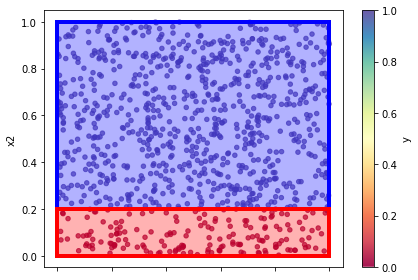

In [75]:
cmap = cm.get_cmap('Spectral')
def draw_tree(ax: plt.Axes, node: Node, bounds: [(float, float), (float, float)]):
    xmin, xmax = bounds[0]
    ymin, ymax = bounds[1]
    if node.class_label != None:
        edgecolor = [0, 0, 1, 1] if node.class_label == 1 else [1, 0, 0, 1]
        facecolor = edgecolor.copy()
        facecolor[3] = 0.3
        ax.add_patch(Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=4, ec=edgecolor, fc=facecolor))
    elif node.feature and node.threshold:
        if node.feature == 'x1':
            draw_tree(ax, node.children[0], [(node.threshold, xmax), (ymin, ymax)])
            draw_tree(ax, node.children[1], [(xmin, node.threshold), (ymin, ymax)])
        elif node.feature == 'x2':
            draw_tree(ax, node.children[0], [(xmin, xmax), (node.threshold, ymax)])
            draw_tree(ax, node.children[1], [(xmin, xmax), (ymin, node.threshold)])

ax = d1_df.plot.scatter(x='x1', y='x2', c='y', alpha=0.7, colormap=cmap)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.tight_layout()
draw_tree(ax, d1_dtree, [(0, 1), (0, 1)])
plt.show()

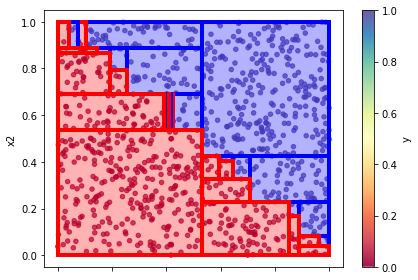

In [76]:
ax = d2_df.plot.scatter(x='x1', y='x2', c='y', alpha=0.7, colormap=cmap)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.tight_layout()
draw_tree(ax, d2_dtree, [(0, 1), (0, 1)])
plt.show()

The two plots above are of the decision trees on D1.txt and D2.txt, respectively.
The first is fairly straightforward: more or less, a straight horizontal line divides the 2 different classes.
The second plot, however straightforward as it seems, causes the decision tree to struggle. Looking at the data points, a diagonal line divides the 2 classes, which on paper is not much more complicated than the data in D1. But since the implementation of this decision tree works by creating thresholds on single features, the horizontal and vertical boundaries can only approximate a diagonal line (all while having a significantly deeper tree than the first). In essence, the hypothesis space of a decision tree limits its effectiveness when working with some datasets.

### 7.
We provide a data set Dbig.txt with 10000 labeled items. Caution: Dbig.txt is sorted.
- You will randomly split Dbig.txt into a candidate training set of 8192 items and a test set (the rest). Do this by generating a random permutation, and split at 8192.
- Generate a sequence of five nested training sets D32 ⊂ D128 ⊂ D512 ⊂ D2048 ⊂ D8192 from the candidate training set. The subscript n in Dn denotes training set size. The easiest way is to take the first n items from the (same) permutation above. This sequence simulates the real world situation where you obtain more and more training data.
- For each Dn above, train a decision tree. Measure its test set error errn. Show three things in your
answer: (1) List n, number of nodes in that tree, errn. (2) Plot n vs. errn. This is known as a learning
curve (a single plot). (3) Visualize your decision trees’ decision boundary (five plots).

In [77]:
dbig_df = pd.read_csv('./data/Dbig.txt', sep='\s+', names=['x1', 'x2', 'y'])
shuffled_df = dbig_df.sample(frac=1).reset_index(drop=True)
training_set = shuffled_df.iloc[:8192]
test_set = shuffled_df.iloc[8192:].reset_index(drop=True)

set32 = training_set.iloc[:32]
set128 = training_set.iloc[:128]
set512 = training_set.iloc[:512]
set2048 = training_set.iloc[:2048]
set8192 = training_set.iloc[:8192]

In [78]:
def test_model_accuracy(model: Node, test_set: pd.DataFrame) -> float:
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, row in test_set.iterrows():
        prediction = model.predict(row[['x1', 'x2']])
        if row['y'] == 1:
            if prediction == 1: true_positives += 1
            elif prediction == 0: false_negatives += 1
        elif row['y'] == 0:
            if prediction == 1: false_positives += 1
            elif prediction == 0: true_negatives += 1
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + \
                                                    false_positives + false_negatives)
    return accuracy

In [79]:
dt32 = make_subtree(set32)
err32 = 1 - test_model_accuracy(dt32, test_set)
print('32\t' + str(dt32.size()) + '\t' + str(err32))

32	9	0.10951327433628322


In [81]:
dt128 = make_subtree(set128)
err128 = 1 - test_model_accuracy(dt128, test_set)
print('128\t' + str(dt128.size()) + '\t' + str(err128))

128	13	0.07632743362831862


In [82]:
dt512 = make_subtree(set512)
err512 = 1 - test_model_accuracy(dt512, test_set)
print('512\t' + str(dt512.size()) + '\t' + str(err512))

512	55	0.04701327433628322


In [83]:
dt2048 = make_subtree(set2048)
err2048 = 1 - test_model_accuracy(dt2048, test_set)
print('2048\t' + str(dt2048.size()) + '\t' + str(err2048))

2048	143	0.028761061946902644


In [84]:
dt8192 = make_subtree(set8192)
err8192 = 1 - test_model_accuracy(dt8192, test_set)
print('8192\t' + str(dt8192.size()) + '\t' + str(err8192))

8192	269	0.009955752212389424


|n       |num nodes       |error                       |run time|
|--------|----------------|----------------------------|--------|
|32      |9               |0.10951327433628322         |0.6s    |
|128     |13              |0.07632743362831862         |0.9s    |
|512     |55              |0.04701327433628322         |3.9s    |
|2048    |143             |0.028761061946902644        |22.5s   |
|8192    |269             |0.009955752212389424        |201.2s  |

Above is the table of data I acquired for each size of training data.
n: size of the training set
num nodes: how many nodes are in the decision tree that modeled the training set
error: the error of the decision tree when run on the testing set
run time: approximation of how long it took to generate the decision tree

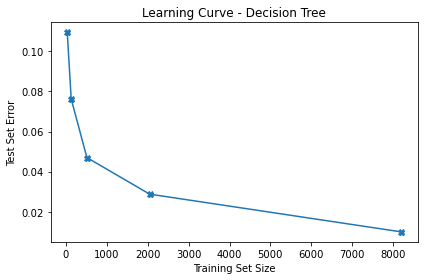

In [105]:
x_data = [32, 128, 512, 2048, 8192]
y_data = [err32, err128, err512, err2048, err8192]
plt.plot(x_data, y_data, marker='X')
plt.xlabel('Training Set Size')
plt.ylabel('Test Set Error')
plt.title('Learning Curve - Decision Tree')
plt.tight_layout()
plt.show()

This is the learning curve of my implementation of a decision tree on this dataset.

Next I'll plot the decision boundaries of each tree size.

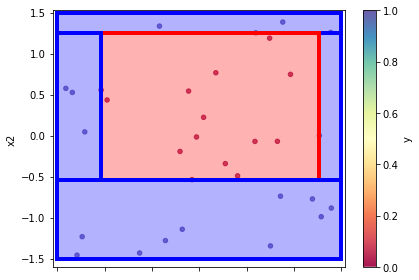

In [107]:
ax = set32.plot.scatter(x='x1', y='x2', c='y', alpha=0.7, colormap=cmap)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.tight_layout()
draw_tree(ax, dt32, [(-1.5, 1.5), (-1.5, 1.5)])
plt.show()

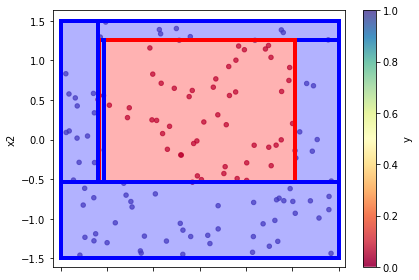

In [90]:
ax = set128.plot.scatter(x='x1', y='x2', c='y', alpha=0.7, colormap=cmap)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.tight_layout()
draw_tree(ax, dt128, [(-1.5, 1.5), (-1.5, 1.5)])
plt.show()

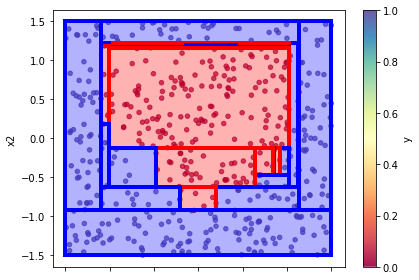

In [91]:
ax = set512.plot.scatter(x='x1', y='x2', c='y', alpha=0.7, colormap=cmap)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.tight_layout()
draw_tree(ax, dt512, [(-1.5, 1.5), (-1.5, 1.5)])
plt.show()

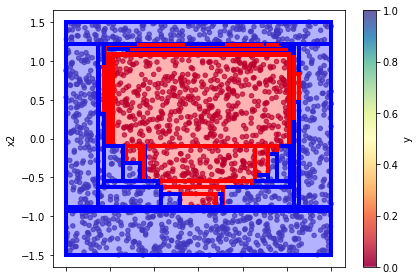

In [92]:
ax = set2048.plot.scatter(x='x1', y='x2', c='y', alpha=0.7, colormap=cmap)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.tight_layout()
draw_tree(ax, dt2048, [(-1.5, 1.5), (-1.5, 1.5)])
plt.show()

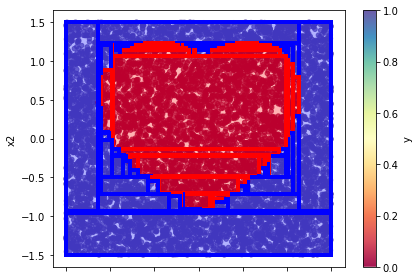

In [93]:
ax = set8192.plot.scatter(x='x1', y='x2', c='y', alpha=0.7, colormap=cmap)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.tight_layout()
draw_tree(ax, dt8192, [(-1.5, 1.5), (-1.5, 1.5)])
plt.show()

It turns out that the dataset resembles a heart!

## 3.    sklearn
Learn to use sklearn https://scikit-learn.org/stable/.
Use sklearn.tree.DecisionTreeClassifier to produce trees for datasets $D_{32}, D_{128}, D_{512}, D_{2048}, D_{8192}$.  Show two things in your answer: (1) List $n$, number of nodes in that tree, $err_n$. (2) Plot $n$ vs. $err_n$.

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# I'll use the default configuration for sklearn's trees.
sk32 = DecisionTreeClassifier()
sk32.fit(set32[['x1', 'x2']], set32['y'])
predictions = sk32.predict(training_set[['x1', 'x2']])
skerr32 = 1 - accuracy_score(training_set['y'], predictions)
print('32\t' + str(sk32.tree_.node_count) + '\t' + str(skerr32))

32	9	0.091552734375


In [100]:
sk128 = DecisionTreeClassifier()
sk128.fit(set128[['x1', 'x2']], set128['y'])
predictions = sk128.predict(training_set[['x1', 'x2']])
skerr128 = 1 - accuracy_score(training_set['y'], predictions)
print('128\t' + str(sk128.tree_.node_count) + '\t' + str(skerr128))

128	13	0.08544921875


In [101]:
sk512 = DecisionTreeClassifier()
sk512.fit(set512[['x1', 'x2']], set512['y'])
predictions = sk512.predict(training_set[['x1', 'x2']])
skerr512 = 1 - accuracy_score(training_set['y'], predictions)
print('512\t' + str(sk512.tree_.node_count) + '\t' + str(skerr512))

512	49	0.044677734375


In [102]:
sk2048 = DecisionTreeClassifier()
sk2048.fit(set2048[['x1', 'x2']], set2048['y'])
predictions = sk2048.predict(training_set[['x1', 'x2']])
skerr2048 = 1 - accuracy_score(training_set['y'], predictions)
print('2048\t' + str(sk2048.tree_.node_count) + '\t' + str(skerr2048))

2048	123	0.0198974609375


In [103]:
sk8192 = DecisionTreeClassifier()
sk8192.fit(set8192[['x1', 'x2']], set8192['y'])
predictions = sk8192.predict(training_set[['x1', 'x2']])
skerr8192 = 1 - accuracy_score(training_set['y'], predictions)
print('8192\t' + str(sk8192.tree_.node_count) + '\t' + str(skerr8192))

8192	247	0.0


|n       |num nodes       |error                       |
|--------|----------------|----------------------------|
|32      |9               |0.091552734375              |
|128     |13              |0.08544921875               |
|512     |49              |0.044677734375              |
|2048    |123             |0.0198974609375             |
|8192    |247             |0.0                         |

Above is the table of data, this time on decision trees made with sklearn.
n: size of the training set
num nodes: how many nodes are in the decision tree that modeled the training set
error: the error of the decision tree when run on the testing set

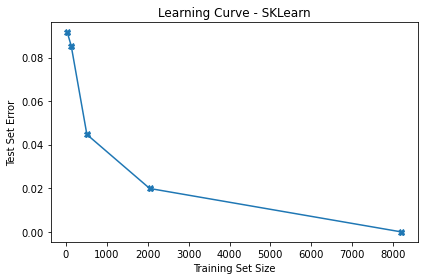

In [104]:
x_data = [32, 128, 512, 2048, 8192]
y_data = [skerr32, skerr128, skerr512, skerr2048, skerr8192]
plt.plot(x_data, y_data, marker='X')
plt.xlabel('Training Set Size')
plt.ylabel('Test Set Error')
plt.title('Learning Curve - SKLearn')
plt.tight_layout()
plt.show()

## 4.    Lagrange Interpolation
Fix some interval $[a, b]$ and sample $n = 100$ points $x$ from this interval uniformly. Use these to build a training set consisting of $n$ pairs $(x, y)$ by setting function $y = sin(x)$.

Build a model $f$ by using Lagrange interpolation, check more details in https://en.wikipedia.org/wiki/Lagrange_polynomial and https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html.

Generate a test set using the same distribution as your test set. Compute and report the resulting model’s train and test error. What do you observe?
Repeat the experiment with zero-mean Gaussian noise $\epsilon$ added to $x$. Vary the standard deviation for $\epsilon$ and report your findings.

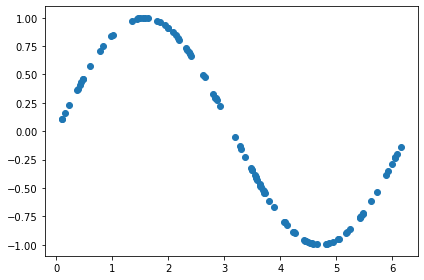

In [170]:
a = 0
b = np.pi * 2
n = 100
x = np.random.uniform(a, b, n)
y = np.sin(x)
plt.scatter(x, y)
plt.tight_layout()
plt.show()

In [171]:
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

lgr = lagrange(x, y)
f = Polynomial(lgr.coef[::-1])

In [172]:
x_test = np.random.uniform(a, b, n)
y_test = np.sin(x_test)

train_rmse = math.sqrt(np.sum((y - f(x))**2) / n)
test_rmse = math.sqrt(np.sum((y_test - f(x_test))**2) / n)
print('Train error (RMSE): ' + str(train_rmse))
print('Test error (RMSE): ' + str(test_rmse))

Train error (RMSE): 1.9328723115535624e+81
Test error (RMSE): 9.206595048001923e+81


The first thing observed with these measured errors is that the train error is far from zero. On paper, a Lagrange interpolation should have zero error on the points used to construct it. The documentation of scipy.interpolate.lagrange suggests the reason for this discrepancy - \
```Warning: This implementation is numerically unstable. Do not expect to be able to use more than about 20 points even if they are chosen optimally.``` \
We're sampling 100 points on a non-polynomial function, so it would make sense for it to be unstable. Even still though, the train error is enormous. The test error in comparison is, as expected, higher than the train error. Test error ~= Train error * 4.

In [176]:
epsilon = np.random.normal(0, 1, n)
new_x_e = x + epsilon
new_y = y
new_f = Polynomial(lagrange(new_x_e, new_y).coef[::-1])
train_rmse_e = math.sqrt(np.sum((new_y - new_f(new_x_e))**2) / n)
test_rmse_e = math.sqrt(np.sum((y_test - new_f(x_test))**2) / n)
print('Train error (RMSE): ' + str(train_rmse_e))
print('Test error (RMSE): ' + str(test_rmse_e))

Train error (RMSE): 6.166294937770386e+82
Test error (RMSE): 5.1159531570909487e+79


Having now introduced some Gaussian noise to x, we observe that the train error has now increased from having no noise. I can't think of a good reason for this case - perhaps just random luck of the instability of the implementation of the Lagrange interpolation. \
The test error, however, is not only less than the train error, but is also lower in comparison to when there was no noise at all. My thinking for as to why this is the case is the relationship between noise and overfitting. Since the Lagrange interpolation can easily, and extremely, overfit to its "training" data, introducing noise on just the training data sort-of lessens the overfitting.

In [180]:
epsilon2 = np.random.normal(0, 10, n)
new_x_e2 = x + epsilon2
new_y2 = y
new_f2 = Polynomial(lagrange(new_x_e2, new_y2).coef[::-1])
train_rmse_e2 = math.sqrt(np.sum((new_y2 - new_f2(new_x_e2))**2) / n)
test_rmse_e2 = math.sqrt(np.sum((y_test - new_f2(x_test))**2) / n)
print('Train error (RMSE): ' + str(train_rmse_e2))
print('Test error (RMSE): ' + str(test_rmse_e2))

Train error (RMSE): 9.138241903352812e+58
Test error (RMSE): 438124935656.58563


With even more variance in the noise introduced to x, the train and test errors are decreased significantly (note still that the error is still egregious and the model is not at all reliable). At this point we're just leading the Lagrange interpolation to be more and more "random" and less reliant on the training data. This reinforces the idea that this noise lessens overfitting in cases like this.